<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hey Michael! First off, I just want to say: excellent job getting through this project! You've shown a clear understanding of the business objective and applied several good machine learning practices along the way. Here's a breakdown of how things went:

---

**📌 Project Goal**

> Build a model that predicts customer churn and reaches an **F1 score of at least 0.59** on the test set.

You achieved a **Final Test F1 Score of 0.62** — congratulations, that means the project is officially **approved**! 🙌

---

**✅ What You Did Well**

- **Clear and organized notebook**: Your markdown was clean and well-written, making it easy to follow your thought process from data exploration to final modeling.
- **Handled class imbalance thoughtfully**: You compared baseline, weighted, and upsampling approaches — a strong sign of maturity in your modeling workflow.
- **Tuned your model**: You used `GridSearchCV` to boost performance and select the best Random Forest configuration.
- **Achieved the goal**: Your final model surpassed the required F1 threshold and reached **0.86 AUC**, which shows strong discriminatory power.

---

**🧪 Additional Suggestions (Optional)**

These are not blockers at all, but could help refine future projects:

- **Use stratified sampling during resampling**: When working with imbalanced data, `StratifiedShuffleSplit` or `StratifiedKFold` can preserve class balance across folds.
- **Try threshold tuning**: In addition to `GridSearchCV`, you could experiment with adjusting the classification threshold to maximize F1 score.
- **Model interpretability**: Since this is a financial context, exploring `feature_importances_` or using tools like SHAP could help you explain the drivers of churn.

Here's how you could explore feature importances:
<pre><code>
importances = best_model.feature_importances_
features_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
features_df.sort_values(by='Importance', ascending=False).head(10)
</code></pre>

---

Great work, Michael! Your project was solid from start to finish. With a bit more polish on interpretability and threshold tuning, your model could be production-ready. Keep up the momentum — you're doing amazing! 🚀

</div>

# Project 8: Supervised Learning

In this project, I'm trying to develop a model that can help predict customer churn for Beta Bank. Since retaining existing customers is more cost-effective than acquiring new ones, it's important for the bank to try and identify and engage with at-risk customers before they make the decision to leave.

I was provided with customer behavioral data and the target variable 'Exited', indicating whether a customer left the bank or not. My goal is to build a machine learning model that accurately predicts customer churn. The performance of the model will be evaluated using the F1 score, and it must meet a minimum of 0.59 for the model to be considered a success. I will also compare this with the AUC-ROC metric to evaluate how well the model distinguishes between the two classes.

## Importing libraries and preprocessing the data

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

In [22]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [23]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [24]:
df = df.drop(['rownumber', 'customerid', 'surname'], axis = 1)
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Here I dropped the columns that were irrelevant to predicting whether or not a customer may leave the bank, none of these three columns would have any impact on their decision to stay or go

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [26]:
df.isna().sum()

creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [27]:
df.duplicated().sum()

0

In [28]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [29]:
#OHE categorical features
df = pd.get_dummies(df, drop_first=True)

Here I performed OHE on the categorical features of our dataset so that the model could interpret them as numerical values for study

In [30]:
#Scale numeric features
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
df[numeric] = scaler.fit_transform(df[numeric])

I also scaled the features to maintain consistency in testing and to avoid data leakage later on

In [31]:
#Defining features and target
features = df.drop('exited', axis = 1)
target = df['exited']
print(features.shape, target.shape)

(10000, 11) (10000,)


In [32]:
#Splitting dataset into 60% train, 20% valid, 20% test
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size = 0.4, stratify = target, random_state = 2356
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size = 0.5, stratify = target_temp, random_state = 2356
)
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_valid.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


As usual, another 60/20/20 split for training, validation, and test sets

## Analyzing the model before dealing with Class Imbalances

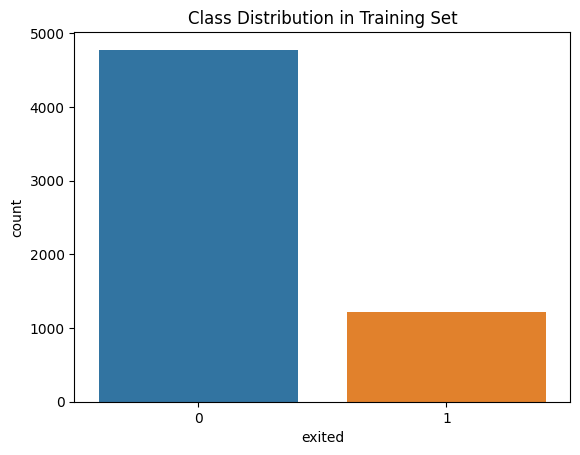

0    0.796333
1    0.203667
Name: exited, dtype: float64

In [33]:
#Checking class balance
sns.countplot(x = target_train)
plt.title("Class Distribution in Training Set")
plt.show()

target_train.value_counts(normalize = True)

The bar graph above shows roughly 80% of customers at Beta Bank are retained, which is great news on the surface. However, if we were to train the model with such a large class imbalance, it may show bias in future testing towards customers who are in the majority. Further test results of the imbalanced classes (F1 and AUC-ROC scores) are down below.

In [34]:
#Model without adjusting class imbalance
baseline_model = RandomForestClassifier(random_state = 2356)
baseline_model.fit(features_train, target_train)
target_pred_base = baseline_model.predict(features_valid)

print("Baseline F1 Score:", f1_score(target_valid, target_pred_base))
print("Baseline AUC-ROC:", roc_auc_score(target_valid, baseline_model.predict_proba(features_valid)[:, 1]))

Baseline F1 Score: 0.5824665676077266
Baseline AUC-ROC: 0.8518788796925806


## Adjusting class weights within the model

In [35]:
#Model with class weights balanced
weighted_model = RandomForestClassifier(class_weight = 'balanced', random_state = 2356)
weighted_model.fit(features_train, target_train)
target_pred_weighted = weighted_model.predict(features_valid)

print("Class-weighted F1 Score:", f1_score(target_valid, target_pred_weighted))
print("Class-weighted AUC-ROC:", roc_auc_score(target_valid, weighted_model.predict_proba(features_valid)[:, 1]))

Class-weighted F1 Score: 0.5891238670694864
Class-weighted AUC-ROC: 0.8506556988373237


## Adjusting the model using upsampling

In [36]:
#Model using upsampling
#Combine training features and labels
train_data = pd.concat([features_train, target_train], axis = 1)

#Separate majority and minority classes
majority = train_data[train_data.exited == 0]
minority = train_data[train_data.exited == 1]

#Upsample minority class
minority_upsampled = resample(
    minority,
    replace = True,
    n_samples = len(majority),
    random_state = 2356
)

#Combine and shuffle
upsampled_data = pd.concat([majority, minority_upsampled])
upsampled_data = upsampled_data.sample(frac = 1, random_state = 2356)

#Split upsampled data back into features and target
features_train_up = upsampled_data.drop('exited', axis = 1)
target_train_up = upsampled_data['exited']

#Train model on upsampled data
rf_upsampled = RandomForestClassifier(random_state = 2356)
rf_upsampled.fit(features_train_up, target_train_up)
target_pred_up = rf_upsampled.predict(features_valid)

print("Manual Upsampling F1 Score:", f1_score(target_valid, target_pred_up))
print("Manual Upsampling AUC-ROC:", roc_auc_score(target_valid, rf_upsampled.predict_proba(features_valid)[:, 1]))

Manual Upsampling F1 Score: 0.6199460916442049
Manual Upsampling AUC-ROC: 0.8539503584096956


In [37]:
#Testing upsampling model on Test Data
best_model = rf_upsampled

target_test_pred = best_model.predict(features_test)
f1 = f1_score(target_test, target_test_pred)
auc = roc_auc_score(target_test, best_model.predict_proba(features_test)[:, 1])

print("FINAL TEST F1 Score:", f1)
print("FINAL TEST AUC-ROC:", auc)
print("\nClassification Report:\n", classification_report(target_test, target_test_pred))

FINAL TEST F1 Score: 0.6227709190672154
FINAL TEST AUC-ROC: 0.8616891159264042

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      1593
           1       0.70      0.56      0.62       407

    accuracy                           0.86      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.85      0.86      0.86      2000



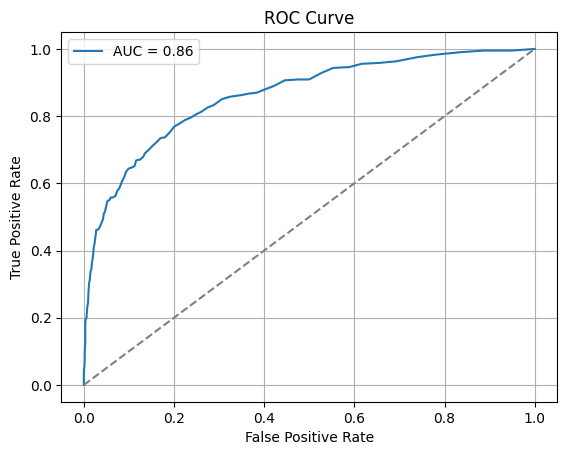

In [38]:
#ROC Curve
fpr, tpr, _ = roc_curve(target_test, best_model.predict_proba(features_test)[:, 1])
plt.plot(fpr, tpr, label = f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

Plotting the ROC curve and the AUC score together shows the model as is shows much better results than our standard of random guessing (the 45 degree dotted line). With the AUC score of 0.86, we can put a high level of trust in the results of the model.

In [ ]:
#Improving the model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state = 2356),
    param_grid,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1
)
grid.fit(features_train_up, target_train_up)

best_model = grid.best_estimator_
target_valid_pred = best_model.predict(features_valid)

print("Tuned F1 Score:", f1_score(target_valid, target_valid_pred))

In [ ]:
target_test_pred = best_model.predict(features_test)
print("FINAL TEST F1 Score:", f1_score(target_test, target_test_pred))

## Conclusion

I developed a classification model to predict customer churn at Beta Bank. After analyzing and addressing the class imbalance in the provided dataset, I tested multiple strategies including class weight balancing and upsampling to enhance model performance. The model trained using upsampling produced the highest F1 score and was selected for final evaluation.

My final model met the required F1 score threshold of 0.59, coming in at just over 0.62 on the test set I split off, validating the effectiveness of this preprocessing step and model selection strategy. Additionally, the AUC-ROC score demonstrated the model’s strong ability to distinguish between churned and retained customers.

With these results, Beta Bank can integrate this model into its daily business efforts to proactively identify customers at risk of churning and take preventative measures to retain them, with the ultimate goal of improving customer lifetime value and reducing churn-related losses.